In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

# create a dataset of images and flatten them
directory = 'generated_data'
dataset = np.array([cv2.cvtColor(cv2.imread(f'{directory}/{file}'), cv2.COLOR_BGR2GRAY)
                    for file in os.listdir(directory)])
dataset = np.reshape(dataset, (dataset.shape[0], 28 * 28))

# split our dataset into training and testing
train, test = train_test_split(dataset, test_size=10000, random_state=0)

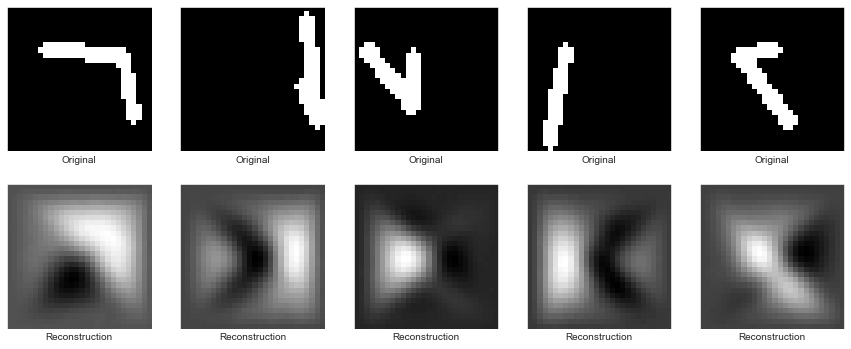

In [2]:
from sklearn.decomposition import PCA

# train a PCA algorithm and apply it to the test data
pca = PCA(n_components=6, svd_solver='full').fit(train/255)
reconstruction = pca.inverse_transform(pca.transform(test/255))
reconstruction = 255 * np.reshape(reconstruction, (test.shape[0], 28, 28))
original = np.reshape(test, (test.shape[0], 28, 28))

# show comparison between reconstruction and originals
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original[i], cmap="gray")
    plt.xlabel('Original')
    plt.subplot(2,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(reconstruction[i], cmap="gray")
    plt.xlabel('Reconstruction')

plt.savefig('results/pca_reconstruction.png')
plt.show()

In [3]:
from keras import layers
from keras.models import Sequential
import tensorflow as tf

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

autoencoder = Sequential(
    [
        layers.Input(784),
        layers.Dense(400, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(6, activation='relu', name='hidden'),
        layers.Dense(25, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(400, activation='relu'),
        layers.Dense(784, activation='sigmoid', name='output')
    ]
)

# now we compile the model with the optimizer and loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
# and now we train the autoencoder
autoencoder.fit(train/255, train/255,
                epochs=75,
                batch_size=256,
                shuffle=True,
                validation_data=(test/255, test/255),
                verbose=0)

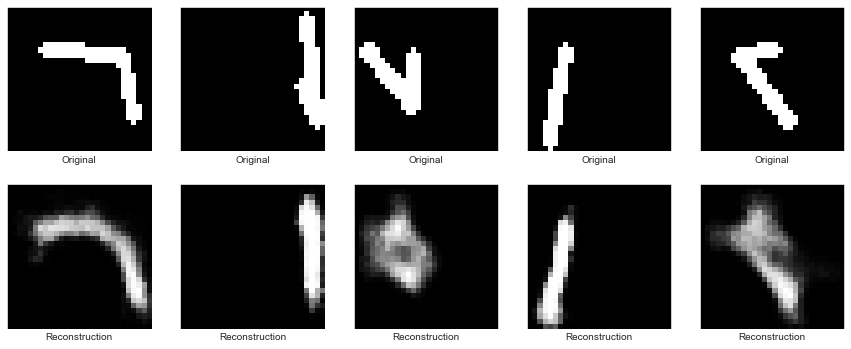

In [5]:
from keras.models import Model

encoder = Model(
    inputs=autoencoder.inputs,
    outputs=autoencoder.get_layer(name='hidden').output,
)

decoder = Model(
    inputs=autoencoder.get_layer(name='hidden').output,
    outputs=autoencoder.get_layer(name='output').output,
)


# for the test set, we now encode and decode some images
encoded_imgs = encoder.predict(test/255)
decoded_imgs = 255 * np.reshape(decoder.predict(encoded_imgs), (test.shape[0], 28, 28))

# show comparison between reconstruction and originals
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original[i], cmap="gray")
    plt.xlabel('Original')
    plt.subplot(2,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(decoded_imgs[i], cmap="gray")
    plt.xlabel('Reconstruction')

plt.savefig('results/autoencoder_reconstruction.png')
plt.show()